In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp,space_eval,rand,Trials,partial,STATUS_OK
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.decomposition import PCA 
from sklearn.naive_bayes import GaussianNB


In [2]:
def load_csv(filename):
    col_names = {
        'PassengerId': 'PassengerId',
        'Survived': 'survived',
        'Pclass': 'pclass',
        'Name': 'name',
        'Sex': 'sex',
        'Age': 'age',
        'SibSp': 'sibsp',
        'Parch': 'parch',
        'Ticket': 'ticket', 
        'Fare': 'fare',
        'Cabin': 'cabin',
        'Embarked': 'port',
    }
    exclude = [
        'PassengerID'
    ]
    dtype = {
        'Pclass': np.uint8,
        'Age': np.float32,
        'SibSp': np.uint8,
        'Parch': np.uint8,
        'Fare': np.float32,
        'survived': np.uint8,
    }
    df = pd.read_csv(
            filename,
            dtype=dtype,
            usecols=lambda x: x not in exclude,
        ).rename(columns=col_names)
    ycol = 'survived'
    if ycol in df.columns:
        return df,df.drop(columns=ycol),df[ycol]
    else:
        return df
    
def load_titanic():
    train_csv = '../input/train.csv'
    test_csv = '../input/test.csv'
    
    X_y,X,y = load_csv(train_csv)
    test = load_csv(test_csv)
    
    traintest = pd.concat([X_y,test],axis = 0)

    return X,y,test,traintest

In [3]:
X,y,test,traintest = load_titanic()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

In [4]:
def sex(X):
    return(
        X
        .sex
        .map({'female':1, 'male':0, np.nan:2})
        .astype(np.uint8)
    )
#xx = sex(X)
#print(xx.value_counts())


def age_level(X):
    def encode(x):
        if x == np.nan:
            return 0
        elif 0<=x<15:
            return 1
        elif 15<=x<48:
            return 2
        else:
            return 3
    return(
        X
        .age
        .apply(encode)
        .astype(np.uint8)
        .rename('age_level')
    )

def ticket_counts(X):
    return(
        X
        .ticket
        .map(traintest.ticket.value_counts())
        .rename('ticket_counts')
    )


def title(X):
    sir = ['sir','capt','don','rev','dr']
    military = ['major','col']
    lady = ['lady','jonkheer', 'the countess', 'dona']
    mlle = ['mme', 'mlle']
    exists = ['mr','miss','mrs','master','dr','rev','major' ,'mlle','col','jonkheer','don','dona','capt' ,'the countess','lady','sir','ms','mme']
    def merge_title(x):
        if x == np.nan:
            return 'other'
        elif x in exists:
            if x in sir:
                return 'sir'
            elif x in lady:
                return 'lady'
            elif x in mlle:
                return 'mlle'
            elif x in military:
                return 'military'
            else:
                return x
        else:
            return 'other'
    return(
        X
        .name
        .str.lower()
        .str.extract(r', ([a-z\s]+).', expand=False)
        .apply(merge_title)
        .rename('title')
    )
# xx = title(traintest)
# print(xx.value_counts())


def surname(X):
    return(
        X
        .name
        .str.lower()
        .str.extract(r'(\w+),', expand=False)
        .rename('surname')
    )
#xx = surname(X)
#print(xx.value_counts())


def cabin_l(X):
    return(
        X
        .cabin
        .apply(lambda x: x!=x and 'o' or x[0].lower())
        .rename('cabin_l')
    )
#xx = cabin_l(X)
#print(xx.value_counts())


def cabin_n(X):
    return(
        X
        .cabin
        .str.lower()
        .str.extract(r'(\d+)', expand=False)
        .astype(np.float32)
        .rename('cabin_n')
    )



def cabin_srv(X):
    def get_srv(x):
        if x.cabin_l=='o':
            return 0
        elif x.cabin_l=='a':
            if x.cabin_n<12:
                return 0
            elif 23<x.cabin_n<30:
                return 2
            else:
                return 1
        elif x.cabin_l=='b':
            return 2
        elif x.cabin_l=='c':
            if 22<x.cabin_n<79 or x.cabin_n>125:
                return 2
            else:
                return 1
        elif x.cabin_l=='d':
            if 40<x.cabin_n<50:
                return 1
            else:
                return 2
        elif x.cabin_l=='e':
            if 50<x.cabin_n<75:
                return 1
            else:
                return 2
        elif x.cabin_l=='f':
            if x.cabin_n<15 or 30<x.cabin_n<40 :
                return 2
            elif 60<x.cabin_n<70:
                return 0
            else:
                return 1
        elif x.cabin_l=='g':
            return 0
        elif x.cabin_l=='t':
            return 0
        
    df = pd.concat([X.cabin, cabin_l(X), cabin_n(X)], axis=1)
    return(
        df
        .apply(get_srv, axis=1)
        .astype(np.uint8)
        .rename('cabin_srv')
    )    
#xx = cabin_srv(X)
#print(xx.value_counts())

def family_size(X):
    return(
        (X.sibsp + X.parch +1)
        .astype(np.uint8)
        .rename('family_size')
    )

def fare_avg(X):
    return(
        (X.fare/ticket_counts(X))
        .astype(np.float32)
        .rename('fare_avg')
    )

def port(X):
    return(
        X
        .port
        .fillna('S')
        .rename('port')
    )

def pclass_sex(X):
    pass

#xx = port(X)
#print(xx.value_counts())

#print(fare_avg(X))
#xx = srv(X)
#print(xx.to_frame())

In [5]:
def deck_encode(X):
    return (
        cabin_l(X)
        .map({
            't': 8,
            'a': 7,
            'b': 6,
            'c': 5,
            'd': 4,
            'e': 3,
            'f': 2,
            'g': 1,
        })
        .astype(np.float32)
        .rename('deck_encode')
    )

In [6]:
def cabin_no_encode(X):
    def encode(x):
        if x.cabin_l == 't':
            return 2
        elif np.isnan(x.cabin_n):
            return np.nan
        elif x.cabin_l == 'a':
            if x.cabin_n >= 35:
                return 4
            else:
                return 2
        elif x.cabin_l == 'b':
            if x.cabin_n >= 51:
                return 3
            else:
                return 2
        elif x.cabin_l == 'c':
            if x.cabin_n % 2 == 0:
                if 92 <= x.cabin_n <= 102 or 142 <= x.cabin_n <= 148:
                    return 4
                elif 62 <= x.cabin_n <= 90 or 104 <= x.cabin_n <= 140:
                    return 3
                else:
                    return 2
            else:
                if 85 <= x.cabin_n <= 93 or 123 <= x.cabin_n <= 127:
                    return 4
                elif 55 <= x.cabin_n <= 83 or 95 <= x.cabin_n <= 121:
                    return 3
                else:
                    return 2
        elif x.cabin_l == 'd':
            if x.cabin_n >= 51:
                return 5
            else:
                return 2
        elif x.cabin_l == 'e':
            if x.cabin_n >= 91:
                return 5
            elif x.cabin_n >= 70:
                return 4
            elif x.cabin_n >= 26:
                return 3
            else:
                return 2
        elif x.cabin_l == 'f':
            if x.cabin_n >= 46:
                return 1
            elif x.cabin_n >= 20:
                return 5
            else:
                return 4
        elif x.cabin_l == 'g':
            return 5
    
    df = pd.concat([X.cabin, cabin_l(X), cabin_n(X)], axis=1)
    return (
        df
        .apply(encode, axis=1)
        .astype(np.float32)
        .rename('cabin_no_encode')
    )


In [7]:
title_category = ['mr','miss','mrs','master','military','ms','mlle','sir','lady','other']
port_category = ['S','C','Q','O']
cabin_category = ['a','b','c','d','e','f','g','t','o']
pclass_category = [1,2,3,0]
age_level_category = [0,1,2,3]
srv_category = [0,1,2,3,4,5]

In [8]:
class DataFrameUnion(BaseEstimator,TransformerMixin):
    def __init__(self, trf_list):
        self.trf_list = trf_list

    def fit(self, X, y=None):
        for t in self.trf_list:
            t.fit(X, y)
        return self

    def transform(self, X):
        return pd.concat([t.transform(X) for t in self.trf_list], axis=1)
    
class ColumnSelector(BaseEstimator,TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
    
class FeatureTransformer(BaseEstimator,TransformerMixin):
    def __init__(self, func):
        self.func = func
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return self.func(X)
    

class ToFrame(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.to_frame()
    
    
class Fillna(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.mean = X.mean()
        return self
    
    def transform(self, X):
        return X.fillna(self.mean)
    
    
    
    
class GetDummies(BaseEstimator,TransformerMixin):
    def __init__(self, drop_first=False, category = None):
        self.drop = drop_first
        self.category = category

    def fit(self, X, y=None):
        self.name = X.name
        if(self.category is None):
            self.cat = pd.Categorical(X.unique())
        else:
            self.cat = pd.Categorical(self.category)
        return self

    def transform(self, X):
        return pd.get_dummies(X.astype(self.cat), prefix=self.name, drop_first=self.drop)



In [9]:
class Feature_surv(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y):
        self.sur_map = y.groupby(surname(X)).max()
        self.tk_map = y.groupby(X.ticket).max()
        return self
        
    def transform(self, X):
        def encode(x):
            sur_srv = x.sur_srv
            tk_srv = x.tk_srv
            if sur_srv==1 or tk_srv==1:
                if sur_srv==1 and tk_srv==1:
                    return z
                elif sur_srv==0 or tk_srv==0:
                    return 2
                else:
                    return 4 
            elif sur_srv==0 or tk_srv==0:
                if sur_srv==0 and tk_srv==0:
                    return 0
                else:
                    return 1
            else:
                return 3
        tk_srv_lst = (
            X
            .ticket
            .map(self.tk_map)
            .astype(np.float32)
            .rename('tk_srv')
        )
        sur_srv_lst = (
            surname(X)
            .map(self.sur_map)
            .astype(np.float32)
            .rename('sur_srv')
        )
        return(
            pd.concat([sur_srv_lst,tk_srv_lst],axis = 1)
                .apply(encode,axis=1)
                .astype(np.float32)
                .rename('srv')
        )


In [10]:
# combined_features = FeatureUnion(
#         transformer_list=[
#             ('pclass', Pipeline([
#                 ('1', ColumnSelector('pclass')),
#                 ('2', GetDummies(category=pclass_category))
#             ])),
            
#             ('title', Pipeline([
#                 ('1', FeatureTransformer(title)),
#                 ('2', GetDummies(category=title_category))
#             ])),
            
#             ('sex', Pipeline([
#                 ('1', FeatureTransformer(sex)),
#                 ('2', ToFrame())
#             ])),

#             ('age', Pipeline([
#                 ('1', FeatureTransformer(age)),
#                 ('2', ToFrame()),
#                 ('3', Imputer()),
#                 ('4', StandardScaler())
#             ])),
            
#             ('age_level', Pipeline([
#                 ('1', FeatureTransformer(age)),
#                 ('2', GetDummies(category=age_level_category))
#             ])),
            
#             ('port', Pipeline([
#                 ('1', FeatureTransformer(port)),
#                 ('2', GetDummies(category=port_category))
#             ])),
            
#             ('cabin_l', Pipeline([
#                 ('1', FeatureTransformer(cabin_l)),
#                 ('2', GetDummies(category=cabin_category))
#             ])),
            
#             ('cabin_n', Pipeline([
#                 ('1', FeatureTransformer(cabin_n)),
#                 ('2', ToFrame()),
#                 ('3', Imputer()),
#                 ('4', StandardScaler())
#             ])),
            
#             ('cabin_srv', Pipeline([
#                 ('1', FeatureTransformer(cabin_srv)),
#                 ('2', ToFrame()),
#                 ('3', StandardScaler())
#             ])),
            
# #             ('srv',Pipeline([
# #                 ('1', Feature_surv()),
# #                 ('2', GetDummies(category=srv_category))
# #             ])),

#             ('fare_avg', Pipeline([
#                 ('1', FeatureTransformer(fare_avg)),
#                 ('2', ToFrame()),
#                 ('3', Imputer()),
#                 ('4', StandardScaler())
#             ])),

#         ]
#     )

In [11]:

def age_deck_encode(X):
    return (
        (X.age * deck_encode(X)).rename('age_deck_encode')
    )

def fare_fare_avg(X):
    return (
        (fare_avg(X) * X.fare).rename('fare_fare_avg')
    )

def age_fare_deck_encode(X):
    return (
        (X.age.fillna(fare_avg(X).mean()) * fare_avg(X).fillna(fare_avg(X).mean()) * deck_encode(X).fillna(deck_encode(X).mean())).rename('age_fare_deck_encode')
    )

def age_fare_pclass(X):
    return (
        (fare_avg(X) * X.age * X.pclass).rename('age_fare_pclass')
    )

def age_pclass(X):
    return (
        (fare_avg(X).fillna(fare_avg(X).mean()) * X.pclass.fillna(X.pclass.mean())).rename('fare_pclass')
    )

def age_female(X):
    def func(x):
        if x.sex == 'female':
            return x.age
        else: return 0
    return (
        X
        .apply(func,axis = 1)
        .astype(np.float32)
        .rename('age_female')
    )

def age_fare_family_size(X):
    return (
        fare_avg(X) * X.age * (X.sibsp + X.parch +1)
        .astype(np.float32)
        .rename('age_family_size')
    )

def female_family_size(X):
    def func(x):
        if x.sex == 'female':
            return (x.sibsp + x.parch +1)
    return X.apply(func,axis = 1).rename('female_family_size')

def female_port_S(X):
    def func(x):
        if x.port == 'S' and x.sex =='female':
            return 1
        else: return 0
    return X.apply(func,axis = 1).rename('female_port_S')

def ticket_family(X):
    return(
        (family_size(X) * ticket_counts(X))
        .rename('ticket_family')
    )


In [14]:

def predict(pipeline):
    pipeline.fit(X_train,y_train)
    metric = cross_val_score(pipeline,X_train,y_train,cv=20,scoring="roc_auc").mean()
    print(metric)
    result = pipeline.predict(X_test)
    print(classification_report(y_true = y_test, y_pred = result))
    print(confusion_matrix(y_true = y_test, y_pred = result))
    return result

In [169]:
xgb_features = DataFrameUnion([
            ColumnSelector('pclass'),
            ColumnSelector('age'),
            FeatureTransformer(deck_encode),
            FeatureTransformer(fare_avg),
            FeatureTransformer(cabin_no_encode),
            FeatureTransformer(age_fare_pclass),
            FeatureTransformer(age_female),
            FeatureTransformer(family_size),
            FeatureTransformer(female_family_size),
            FeatureTransformer(ticket_counts),
            FeatureTransformer(ticket_family)
        ]
    )

In [83]:
clf_xgb = xgb.XGBClassifier(
    max_depth = 3,
    gamma = 0.8038158384678936,
    learning_rate = 0.08980987080617378,
    subsample = 0.6370012579774711,
    min_child_weight = 8.745123021845027,
    max_delta_step = 10,  #10步不降则停止
    objective="binary:logistic"
)

In [84]:
pipeline = Pipeline([
    ('features',xgb_features),
    ('xgb',clf_xgb)
])

0.8489781052281054
             precision    recall  f1-score   support

          0       0.83      0.92      0.87       110
          1       0.84      0.71      0.77        69

avg / total       0.84      0.84      0.83       179

[[101   9]
 [ 20  49]]


C:\Users\Shang\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


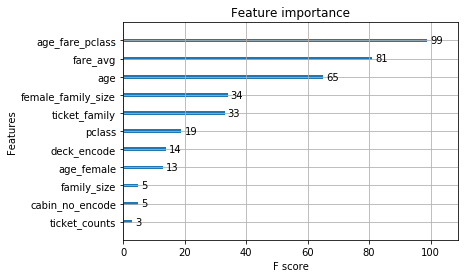

In [85]:
pipeline.fit(X_train,y_train)
metric = cross_val_score(pipeline,X_train,y_train,cv=20,scoring="roc_auc").mean()
print(metric)
xgb.plot_importance(clf_xgb)
result1 = pipeline.predict(X_test)
print(classification_report(y_true = y_test, y_pred = result1))
print(confusion_matrix(y_true = y_test, y_pred = result1))

In [170]:
def xgb_model(argsDict):
    max_depth = argsDict["max_depth"]
    gamma = argsDict["gamma"]
    learning_rate = argsDict["learning_rate"]
    subsample = argsDict["subsample"]
    min_child_weight = argsDict["min_child_weight"]
    colsample_bytree = argsDict["colsample_bytree"]
    clf_xgb = xgb.XGBClassifier(
        nthread=4,    #进程数
        max_depth=max_depth,  #最大深度
        gamma =gamma,
        learning_rate=learning_rate, #学习率
        subsample=subsample,      #采样数
        min_child_weight=min_child_weight,   #孩子数
        colsample_bytree = colsample_bytree,
        max_delta_step = 10,  #10步不降则停止
        objective="binary:logistic",
        eval_metric = 'logloss',
    )
    return clf_xgb

def obj_func(argsDict):
    clf_xgb = xgb_model(argsDict)
        
    pipeline = Pipeline([
        ('features',xgb_features),
        ('xgb',clf_xgb)
    ])
    global X_train, y_train
    
#     print(clf_xgb)
    metric = cross_val_score(pipeline,X_train,y_train,cv=10,scoring="roc_auc").mean()
    print(metric)
    
    return -metric

In [87]:
xgb_space = {
    "max_depth": hp.randint("max_depth",20),
    "gamma": hp.uniform("gamma",0,1),
    "learning_rate": hp.uniform("learning_rate",0.005,0.2),  #[0,1,2,3,4,5] -> 0.05,0.06
    "subsample": hp.uniform("subsample",0.1,0.99),#[0,1,2,3] -> [0.7,0.8,0.9,1.0]
    "min_child_weight": hp.uniform("min_child_weight",0,20), #
    "colsample_bytree": hp.uniform("colsample_bytree",0.5,1),
}

xgb_best = fmin(obj_func,xgb_space,algo=tpe.suggest,max_evals=30)

print(xgb_best)

0.8541249286888821
0.8475551822208798
0.8493094007628891
0.8613184376992515
0.8579481484277995
0.8580298416054231
0.837586691947157
0.5
0.8365644960121704
0.6880630082664967
0.8564285924024297
0.8450948787431345
0.83735115551976
0.8510562085416735
0.8393400365784085
0.8587557817935725
0.6544546726959517
0.5
0.8453726425383401
0.8510941013121245
0.8551610023267001
0.8570621427452823
0.8523003428526683
0.8528851988881059
0.8536210317460317
0.8556017329999888
0.8513136626508719
0.8423924320726647
0.8419348174435383
0.8598869369218207
{'colsample_bytree': 0.6005098869470216, 'gamma': 0.17786650767894474, 'learning_rate': 0.01320671921339444, 'max_depth': 16, 'min_child_weight': 2.7287216389596924, 'subsample': 0.8467292416247054}


In [171]:
xgb_best = {'colsample_bytree': 0.7918887348402697, 'gamma': 0.6122174856269007, 'learning_rate': 0.05213833857251346, 'max_depth': 6, 'min_child_weight': 0.6628373714745606, 'subsample': 0.791701473926328}

In [172]:
final_xgb = Pipeline([
    ('features',xgb_features),
    ('xgb',xgb_model(xgb_best))
])

xgb_result = predict(final_xgb)

0.8613615551115551
             precision    recall  f1-score   support

          0       0.82      0.93      0.87       110
          1       0.85      0.68      0.76        69

avg / total       0.83      0.83      0.83       179

[[102   8]
 [ 22  47]]


C:\Users\Shang\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [173]:
rf_features = DataFrameUnion([
            make_pipeline(
                ColumnSelector('pclass'),
                GetDummies(category=pclass_category)
            ),
            
            make_pipeline(
                FeatureTransformer(title),
                GetDummies(category=title_category)
            ),
            
            make_pipeline(
                ColumnSelector('sex'),
                GetDummies()
            ),
    
            make_pipeline(
                ColumnSelector('age'),   
                Fillna()
            ),

            make_pipeline(
                ColumnSelector('fare'),  
                Fillna()
            ),
            
            make_pipeline(
                FeatureTransformer(port),
                GetDummies(category=port_category)
            ),
            
            make_pipeline(
                FeatureTransformer(cabin_l),
                GetDummies(category=cabin_category)
            ),

        ]
    )

In [110]:
clf_rf = RandomForestClassifier(n_estimators = 150)

In [135]:
pipeline_rf = Pipeline([
    ('features',rf_features),
    ('rf',clf_rf)
])

In [136]:
feat_labels = rf_features.fit_transform(X_train,y_train).columns[1:]

In [137]:
def rf_importance(forest,feat_labels):
    print("Features sorted by their score:")
    importances = forest.feature_importances_
    indices = np.argsort(importances)[::-1]
    for f in range(feat_labels.shape[0]):
        print("%2d) %-*s %f" % (f + 1, 30, feat_labels[f], importances[indices[f]]))

In [138]:
pipeline_rf.fit(X_train,y_train)
metric = cross_val_score(pipeline_rf,X,y,cv=20,scoring="roc_auc").mean()
print(metric)
# rf_importance(clf_rf,feat_labels)
result2 = pipeline_rf.predict(X_test)
print(classification_report(y_true = y_test, y_pred = result2))
print(confusion_matrix(y_true = y_test, y_pred = result2))

0.8658749610955493
             precision    recall  f1-score   support

          0       0.83      0.89      0.86       110
          1       0.80      0.71      0.75        69

avg / total       0.82      0.82      0.82       179

[[98 12]
 [20 49]]


In [174]:
def rf_model(argsDict):
    max_features = argsDict["max_features"]
    n_estimators  = argsDict["n_estimators"]
    min_samples_leaf = argsDict["min_samples_leaf"]
    clf_rf = RandomForestClassifier(
        n_estimators = n_estimators,    
        max_features = max_features,  
        min_samples_leaf = min_samples_leaf, 
    )
    return clf_rf

def obj_func(argsDict):
    clf_rf = rf_model(argsDict)
        
    pipeline = Pipeline([
        ('features',rf_features),
        ('xgb',clf_rf)
    ])
    global X_train, y_train
    
    metric = cross_val_score(pipeline,X_train,y_train,cv=10,scoring="roc_auc").mean()
    print(metric)
    return -metric



In [116]:
rf_space = {
    "n_estimators": hp.randint("n_estimators",200),
    "max_features": hp.uniform("max_features",0,1),
    "min_samples_leaf": hp.randint("min_samples_leaf",100),  #[0,1,2,3,4,5] -> 0.05,0.06
}

rf_best = fmin(obj_func,rf_space,algo=tpe.suggest,max_evals=30)

print(rf_best)

0.8457642594270501
0.8143478318623666
0.8383400379766659
0.8607488576238576
0.8416406241260892
0.8122208729040123
0.8335456586910077
0.8324178943364989
0.8337777344318041
0.8585032914974775
0.8536481928923789
0.8355081126883451
0.8403772288219962
0.8361717605176908
0.8632755783191829
0.8378755718871999
0.8657930705169076
0.8365801914493775
0.8394798622996298
0.8432346723044398
0.8236260375068515
0.8593189648422207
0.8370669597413783
0.861516465876931
0.8458130586037562
0.8326112383525175
0.8374062468539213
0.8600014541875007
0.8389556207143416
0.8413608328579258
{'max_features': 0.5562539237394152, 'min_samples_leaf': 4, 'n_estimators': 198}


In [175]:
rf_best = {'max_features': 0.5562539237394152, 'min_samples_leaf': 4, 'n_estimators': 198}
final_rf = Pipeline([
    ('features',rf_features),
    ('xgb',rf_model(rf_best))
])

rf_result = predict(final_rf)

0.8690413752913753
             precision    recall  f1-score   support

          0       0.84      0.93      0.88       110
          1       0.86      0.72      0.79        69

avg / total       0.85      0.85      0.85       179

[[102   8]
 [ 19  50]]


In [18]:
class Scaling(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y):
        self.mean = X.mean()
        self.var = X.std()
        return self
        
    def transform(self, X):
        return X.apply(lambda x: (x-self.mean)/self.var)

In [314]:
logistic_features = DataFrameUnion([
            make_pipeline(
                ColumnSelector('pclass'),
                GetDummies(category=pclass_category)
            ),
            
            make_pipeline(
                FeatureTransformer(title),
                GetDummies(category=title_category)
            ),
            
            FeatureTransformer(sex),
    
            make_pipeline(
                ColumnSelector('age'),   
                Fillna(),
                Scaling()
            ),


#             make_pipeline(
#                 ColumnSelector('fare'),  
#                 Fillna(),
#                 Scaling()
#             ),

            make_pipeline(
                FeatureTransformer(fare_avg),
                Fillna(),
                Scaling()
            ),
    
            FeatureTransformer(ticket_counts),
                  
            make_pipeline(
                FeatureTransformer(port),
                GetDummies(category=port_category)
            ),
            
#             make_pipeline(
#                 FeatureTransformer(cabin_l),
#                 GetDummies(category=cabin_category)
#             ),
    
            make_pipeline(
                FeatureTransformer(deck_encode),
                Fillna(),
                Scaling()
            ),
    
#             make_pipeline(
#                 FeatureTransformer(cabin_n), 
#                 Fillna(),
#                 Scaling()
#             ),
    
            make_pipeline(
                FeatureTransformer(cabin_no_encode),
                Fillna(),
                Scaling()
            ),
            
            make_pipeline(
                FeatureTransformer(family_size),
                Fillna(),
                Scaling()
            ),
    
#             make_pipeline(
#                 FeatureTransformer(age_female),
#                 Fillna(),
#                 Scaling()
#             ),
    
#             make_pipeline(
#                 FeatureTransformer(female_family_size),
#                 Fillna(),
#                 Scaling()
#             ),

        ]
    )

In [315]:
clf_logistic = LogisticRegression(solver = 'liblinear')
pipeline_logistic = Pipeline([
    ('features',logistic_features),
#     ('pca',PCA(n_components = 13)),
    ('logistic',clf_logistic)
])

In [329]:
pipeline_logistic.fit(X_train,y_train)
metric = cross_val_score(pipeline_logistic,X,y,cv=20,scoring="roc_auc").mean()
print(metric)
logistic_result = pipeline_logistic.predict(X_test)
print(classification_report(y_true = y_test, y_pred = logistic_result))
print(confusion_matrix(y_true = y_test, y_pred = logistic_result))

0.8699832710862123
             precision    recall  f1-score   support

          0       0.88      0.84      0.86       110
          1       0.76      0.81      0.78        69

avg / total       0.83      0.83      0.83       179

[[92 18]
 [13 56]]


In [144]:
v = ((xgb_result + rf_result ) > 1).astype(int)
print(classification_report(y_true = y_test, y_pred = v))
print(confusion_matrix(y_true = y_test, y_pred = v))

             precision    recall  f1-score   support

          0       0.83      0.95      0.89       110
          1       0.90      0.68      0.78        69

avg / total       0.86      0.85      0.84       179

[[105   5]
 [ 22  47]]


C:\Users\Shang\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [65]:
final_stacking = sclf
final_stacking.fit(X,y)
submit = final_stacking.predict(test)
survived = pd.DataFrame({'Survived':submit})
submit_csv = pd.concat([test.PassengerId,survived],axis=1)
#print(submit)
submit_csv.to_csv('submit.csv',index=False) 

C:\Users\Shang\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Shang\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [290]:
nb_features = DataFrameUnion([
#             make_pipeline(
#                 ColumnSelector('pclass'),
#                 GetDummies(category=pclass_category)
#             ),
            
#             make_pipeline(
#                 FeatureTransformer(title),
#                 GetDummies(category=title_category)
#             ),
            
            FeatureTransformer(sex),
    
            make_pipeline(
                ColumnSelector('age'),   
                Fillna(),
                Scaling()
            ),


#             make_pipeline(
#                 ColumnSelector('fare'),  
#                 Fillna(),
#                 Scaling()
#             ),

            make_pipeline(
                FeatureTransformer(fare_avg),
                Fillna(),
                Scaling()
            ),
    
            FeatureTransformer(ticket_counts),
                  
#             make_pipeline(
#                 FeatureTransformer(port),
#                 GetDummies(category=port_category)
#             ),
            
#             make_pipeline(
#                 FeatureTransformer(cabin_l),
#                 GetDummies(category=cabin_category)
#             ),
    
#             make_pipeline(
#                 FeatureTransformer(deck_encode),
#                 Fillna(),
#                 Scaling()
#             ),
    
#             make_pipeline(
#                 FeatureTransformer(cabin_n), 
#                 Fillna(),
#                 Scaling()
#             ),
    
#             make_pipeline(
#                 FeatureTransformer(cabin_no_encode),
#                 Fillna(),
#                 Scaling()
#             ),
            
            make_pipeline(
                FeatureTransformer(family_size),
                Fillna(),
                Scaling()
            ),
    
#             make_pipeline(
#                 FeatureTransformer(age_female),
#                 Fillna(),
#                 Scaling()
#             ),
    
#             make_pipeline(
#                 FeatureTransformer(female_family_size),
#                 Fillna(),
#                 Scaling()
#             ),

        ]
    )

In [327]:
from sklearn.ensemble import BaggingClassifier
clf_nb_bagging = BaggingClassifier(
    base_estimator=GaussianNB()
)

pipeline_nb_bagging = Pipeline([
    ('features',nb_features),
#     ('pca',PCA(n_components = 13)),
    ('nb_bagging',clf_nb_bagging)
])

In [328]:
nb_result = predict(pipeline_nb_bagging)

0.8187957875457876
             precision    recall  f1-score   support

          0       0.85      0.85      0.85       110
          1       0.76      0.77      0.76        69

avg / total       0.82      0.82      0.82       179

[[93 17]
 [16 53]]


In [345]:
knn_features = DataFrameUnion([
            make_pipeline(
                ColumnSelector('pclass'),
                GetDummies(category=pclass_category)
            ),
            
            make_pipeline(
                FeatureTransformer(title),
                GetDummies(category=title_category)
            ),
            
            FeatureTransformer(sex),
    
            make_pipeline(
                ColumnSelector('age'),   
                Fillna(),
                Scaling()
            ),


#             make_pipeline(
#                 ColumnSelector('fare'),  
#                 Fillna(),
#                 Scaling()
#             ),

            make_pipeline(
                FeatureTransformer(fare_avg),
                Fillna(),
                Scaling()
            ),
                  
            make_pipeline(
                FeatureTransformer(port),
                GetDummies(category=port_category)
            ),
            
#             make_pipeline(
#                 FeatureTransformer(cabin_l),
#                 GetDummies(category=cabin_category)
#             ),
    
            make_pipeline(
                FeatureTransformer(deck_encode),
                Fillna(),
                Scaling()
            ),
    
#             make_pipeline(
#                 FeatureTransformer(cabin_n), 
#                 Fillna(),
#                 Scaling()
#             ),
    
            make_pipeline(
                FeatureTransformer(cabin_no_encode),
                Fillna(),
                Scaling()
            ),
            
            make_pipeline(
                FeatureTransformer(family_size),
                Fillna(),
                Scaling()
            ),
    
            FeatureTransformer(ticket_counts)
    
#             make_pipeline(
#                 FeatureTransformer(age_female),
#                 Fillna(),
#                 Scaling()
#             ),
    
#             make_pipeline(
#                 FeatureTransformer(female_family_size),
#                 Fillna(),
#                 Scaling()
#             ),

        ]
    )

In [346]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier(n_neighbors= 10, n_jobs = -1)
pipeline_knn = Pipeline([
    ('features',knn_features),
#     ('pca',PCA(n_components = 13)),
    ('knn',clf_knn)
])

In [347]:
knn_result = predict(pipeline_knn)

0.8499916749916749
             precision    recall  f1-score   support

          0       0.83      0.91      0.87       110
          1       0.83      0.70      0.76        69

avg / total       0.83      0.83      0.82       179

[[100  10]
 [ 21  48]]


In [351]:
param_grid = dict(
    knn__n_neighbors = [17,18,19,20,21,22],
    knn__weights = ['uniform','distance']
)
grid_search = GridSearchCV(pipeline_knn, param_grid=param_grid, verbose=10, scoring='roc_auc',cv=5)
grid_search.fit(X_train, y_train)
final_knn = grid_search.best_estimator_

print(final_knn)
print(grid_search.best_score_ ) 

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] knn__n_neighbors=17, knn__weights=uniform .......................
[CV]  knn__n_neighbors=17, knn__weights=uniform, score=0.8193181818181818, total=   0.1s
[CV] knn__n_neighbors=17, knn__weights=uniform .......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  knn__n_neighbors=17, knn__weights=uniform, score=0.865805785123967, total=   0.1s
[CV] knn__n_neighbors=17, knn__weights=uniform .......................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV]  knn__n_neighbors=17, knn__weights=uniform, score=0.8412190082644628, total=   0.1s
[CV] knn__n_neighbors=17, knn__weights=uniform .......................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s


[CV]  knn__n_neighbors=17, knn__weights=uniform, score=0.8154461279461279, total=   0.1s
[CV] knn__n_neighbors=17, knn__weights=uniform .......................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s


[CV]  knn__n_neighbors=17, knn__weights=uniform, score=0.880055342699021, total=   0.1s
[CV] knn__n_neighbors=17, knn__weights=distance ......................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s remaining:    0.0s


[CV]  knn__n_neighbors=17, knn__weights=distance, score=0.8297520661157024, total=   0.1s
[CV] knn__n_neighbors=17, knn__weights=distance ......................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.9s remaining:    0.0s


[CV]  knn__n_neighbors=17, knn__weights=distance, score=0.85, total=   0.1s
[CV] knn__n_neighbors=17, knn__weights=distance ......................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.2s remaining:    0.0s


[CV]  knn__n_neighbors=17, knn__weights=distance, score=0.8366735537190082, total=   0.1s
[CV] knn__n_neighbors=17, knn__weights=distance ......................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.6s remaining:    0.0s


[CV]  knn__n_neighbors=17, knn__weights=distance, score=0.7977693602693603, total=   0.1s
[CV] knn__n_neighbors=17, knn__weights=distance ......................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.9s remaining:    0.0s


[CV]  knn__n_neighbors=17, knn__weights=distance, score=0.8707960834397616, total=   0.1s
[CV] knn__n_neighbors=18, knn__weights=uniform .......................
[CV]  knn__n_neighbors=18, knn__weights=uniform, score=0.8193181818181818, total=   0.1s
[CV] knn__n_neighbors=18, knn__weights=uniform .......................
[CV]  knn__n_neighbors=18, knn__weights=uniform, score=0.86900826446281, total=   0.1s
[CV] knn__n_neighbors=18, knn__weights=uniform .......................
[CV]  knn__n_neighbors=18, knn__weights=uniform, score=0.8515495867768594, total=   0.1s
[CV] knn__n_neighbors=18, knn__weights=uniform .......................
[CV]  knn__n_neighbors=18, knn__weights=uniform, score=0.8227062289562289, total=   0.1s
[CV] knn__n_neighbors=18, knn__weights=uniform .......................
[CV]  knn__n_neighbors=18, knn__weights=uniform, score=0.8799489144316731, total=   0.1s
[CV] knn__n_neighbors=18, knn__weights=distance ......................
[CV]  knn__n_neighbors=18, knn__weights=d

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   19.8s finished


In [353]:
knn_result = predict(final_knn)

0.8488969363969364
             precision    recall  f1-score   support

          0       0.84      0.94      0.89       110
          1       0.88      0.72      0.79        69

avg / total       0.86      0.85      0.85       179

[[103   7]
 [ 19  50]]


In [376]:
v = ((xgb_result + 2 * rf_result + logistic_result + 2 * knn_result + nb_result )/7 > 0.5).astype(int)
print(classification_report(y_true = y_test, y_pred = v))
print(confusion_matrix(y_true = y_test, y_pred = v))

             precision    recall  f1-score   support

          0       0.85      0.95      0.90       110
          1       0.89      0.74      0.81        69

avg / total       0.87      0.87      0.86       179

[[104   6]
 [ 18  51]]


In [377]:
final_xgb.fit(X,y)
submit1 = final_xgb.predict(test)

final_rf.fit(X,y)
submit2 = final_rf.predict(test)

pipeline_logistic.fit(X,y)
submit3 = pipeline_logistic.predict(test)

pipeline_nb.fit(X,y)
submit4 = final_xgb.predict(test)

final_knn.fit(X,y)
submit5 = final_rf.predict(test)

submit = (( submit1 + 2 * submit2 + submit3 + submit4 + 2 * submit5)/7 > 0.5).astype(int)
survived = pd.DataFrame({'Survived':submit})
submit_csv = pd.concat([test.PassengerId,survived],axis=1)
#print(submit)
submit_csv.to_csv('submit.csv',index=False) 

C:\Users\Shang\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Shang\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
